# Testing

In [ ]:
# Load and resize the image
#image = Image.open(PATH + "/NewFiles2/Ambulance/ambulance90.png")
image = Image.open('siren.png')
image = image.resize((155, 92))  # Resize to match the expected input shape

if image.mode == 'RGBA':
    image = image.convert('RGB')

plt.imshow(image)
image_array = np.array(image)

# Add a batch dimension to the image
input_image = np.expand_dims(image_array, axis=0)
x = input_image/255.0

print(x.shape)

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
print(model.predict(x))
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
n=0
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid_size = (size, size * n_features)
    print(display_grid_size[0])

    display_grid = np.zeros(display_grid_size)

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      x_resized = cv2.resize(x, (display_grid_size[0], display_grid_size[0]))

      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x_resized

# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
    plt.savefig("SirenCNN"+str(n), bbox_inches='tight', pad_inches=0)
    n+=1


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
def to_spec_wav(path):
  y, sr = librosa.load(path)

  # Compute the spectrogram
  spectrogram = librosa.stft(y)

  # Convert the spectrogram to decibel scale
  spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

  # Display the spectrogram without axes
  plt.figure(figsize=(10, 6))
  plt.axis('off')
  librosa.display.specshow(spectrogram_db, sr=sr, x_axis='off', y_axis='off')

  # Save the spectrogram as an image file
  plt.savefig(path.replace('wav','png'), bbox_inches='tight', pad_inches=0)

  # Close the plot
  plt.close()

In [ ]:
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [ ]:
# Declare constants
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 2

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(PATH+"/Mel/"),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(PATH+"/Mel/"),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)
# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(PATH+"/Mel/"),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 1834 files belonging to 2 classes.
Using 1468 files for training.
Found 1834 files belonging to 2 classes.
Using 366 files for validation.


16
(3, 3, 16)


IndexError: ignored

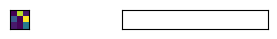

In [ ]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        #print(layer.name, filters.shape)

        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(filters.shape[3])
        filter_cnt=1
        print(filt.shape)
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

# Tool

In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2
import librosa
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keract import get_activations, display_activations, display_heatmaps


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PR = '/content/gdrive/MyDrive/RoadSounds/Road Noises/'
PA = '/content/gdrive/MyDrive/RoadSounds/Ambulance data/'
PATH = '/content/gdrive/MyDrive/RoadSounds/'
IA = '/content/gdrive/MyDrive/RoadSounds/Mel/Ambulance/'
IR = '/content/gdrive/MyDrive/RoadSounds/Mel/Road/'
DIR = [IA,IR]

In [ ]:
model = tf.keras.models.load_model(PATH + "/model_best")

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 13, 101, 16)       160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 50, 16)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 50, 32)         4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 25, 64)         18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 12, 64)      

(25, 201)


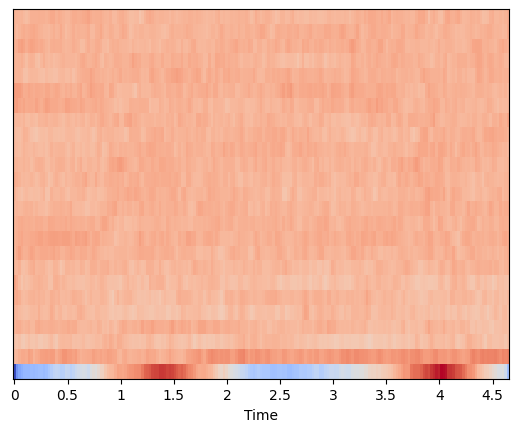

In [ ]:
data, sr = librosa.load(PATH  + "Chunks/road100chunk_1.wav", mono=True)
win_length=int(0.1*sr)
hop_length= int(0.25 * win_length)

n_fft=int(0.25 * sr)
n_mfcc=25

spectrogram = librosa.feature.mfcc(y=data, n_fft=n_fft,hop_length=hop_length,n_mfcc=n_mfcc, win_length = win_length, fmax =5000, fmin=500)
print(spectrogram.shape)
img2 = librosa.display.specshow(spectrogram, x_axis='time', sr=sr)
plt.show()

In [ ]:
spectrogram = np.expand_dims(spectrogram, axis=0)  # Add batch dimension
spectrogram = np.expand_dims(spectrogram, axis=-1)
spectrogram.shape

(1, 25, 201, 1)

In [ ]:
activations = get_activations(model, spectrogram)

input_4 (1, 25, 201, 1) 


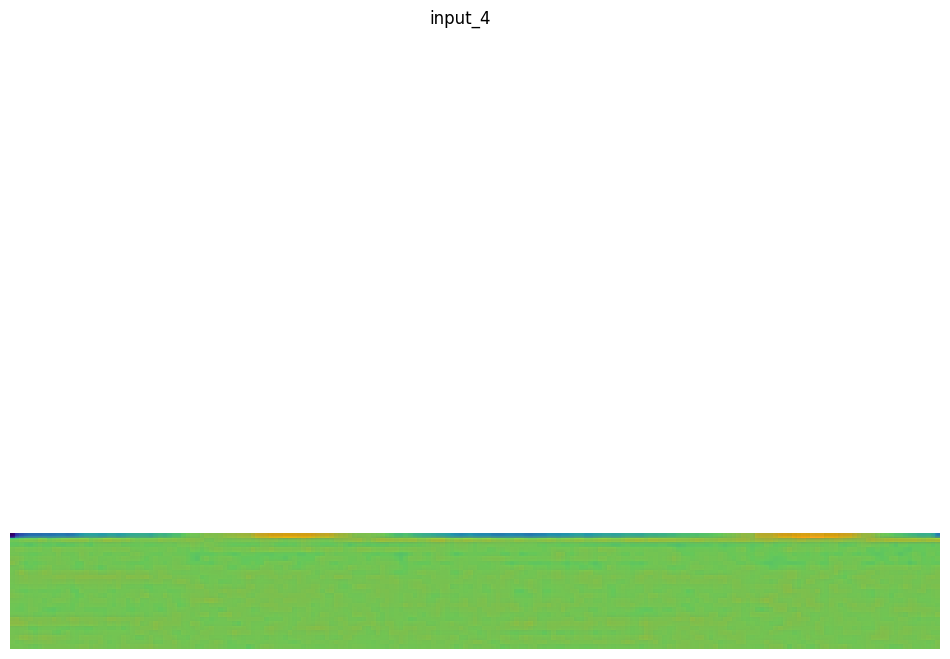

conv2d_9 (1, 13, 101, 16) 


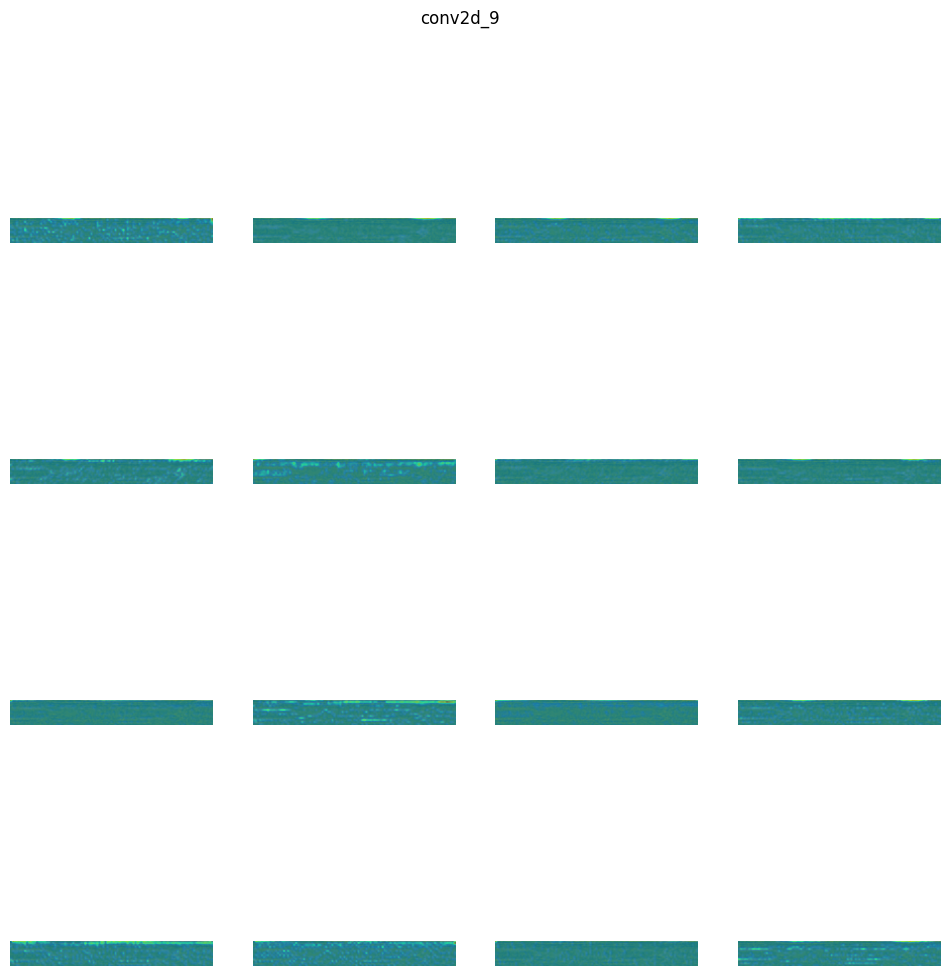

max_pooling2d_9 (1, 6, 50, 16) 


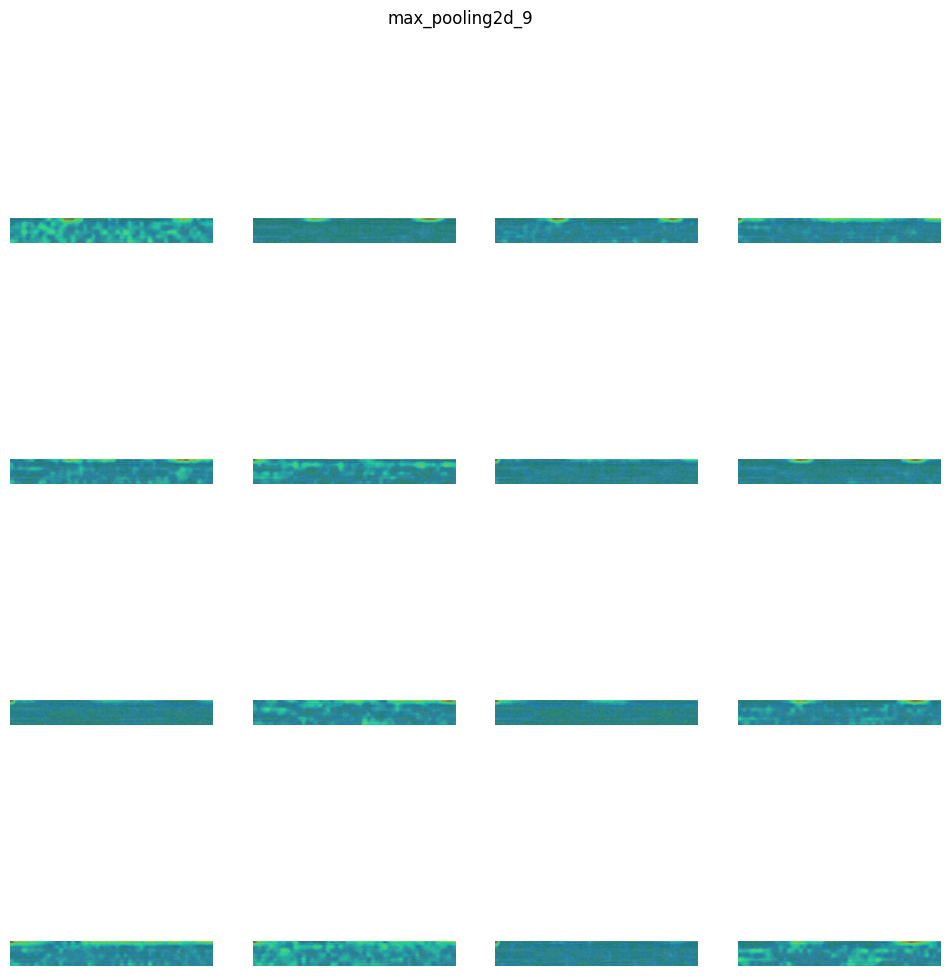

conv2d_10 (1, 6, 50, 32) 


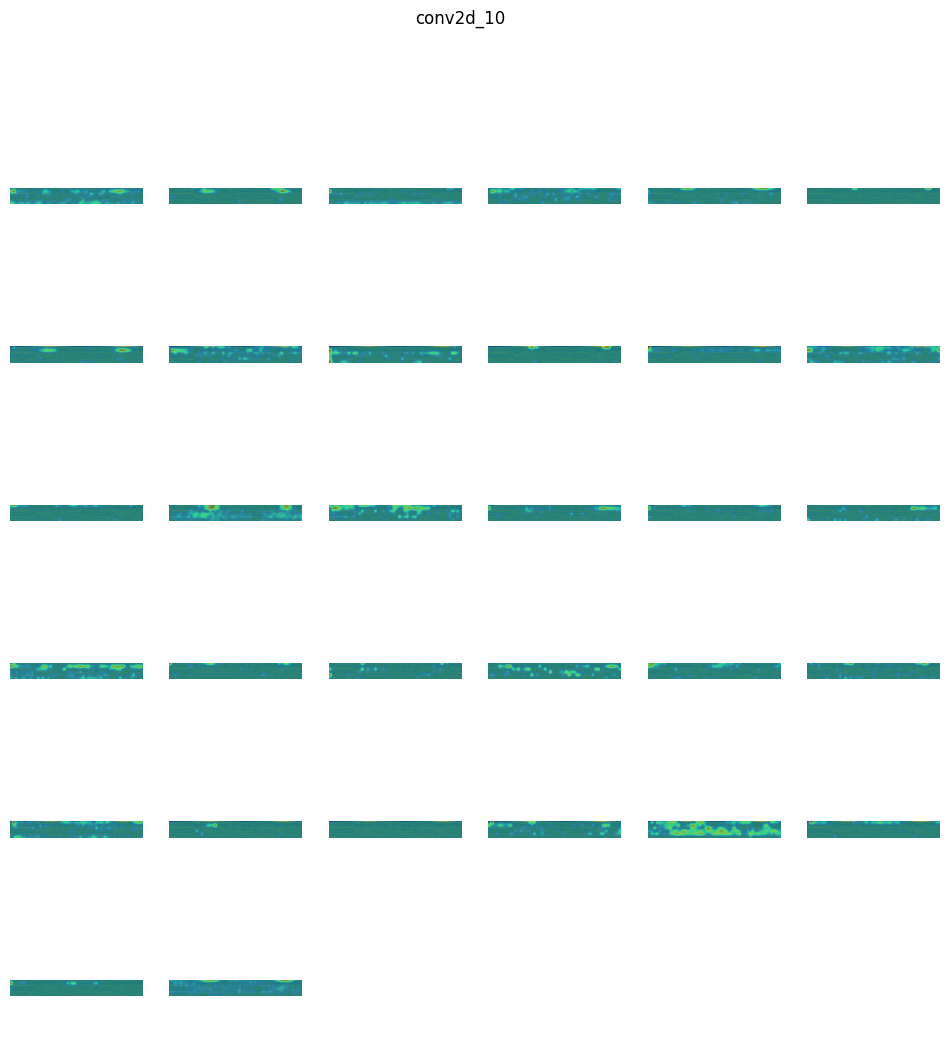

max_pooling2d_10 (1, 3, 25, 32) 


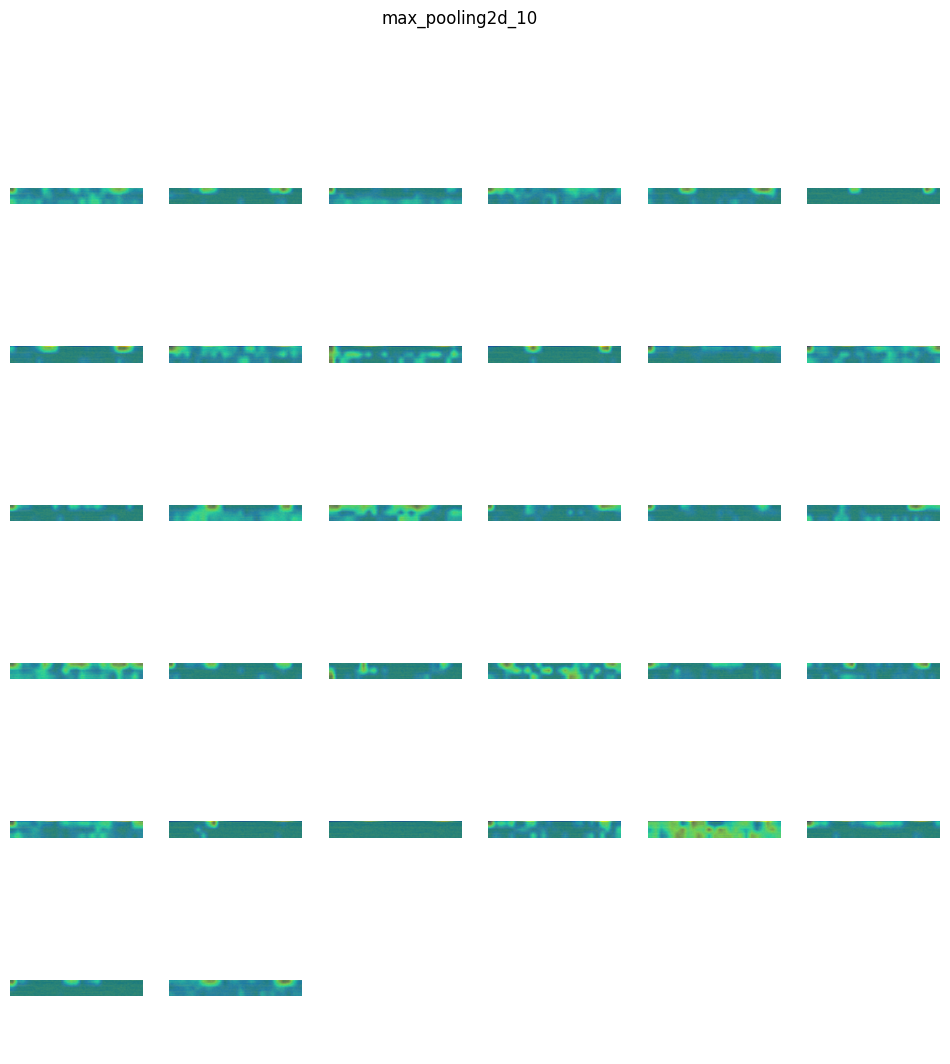

conv2d_11 (1, 3, 25, 64) 


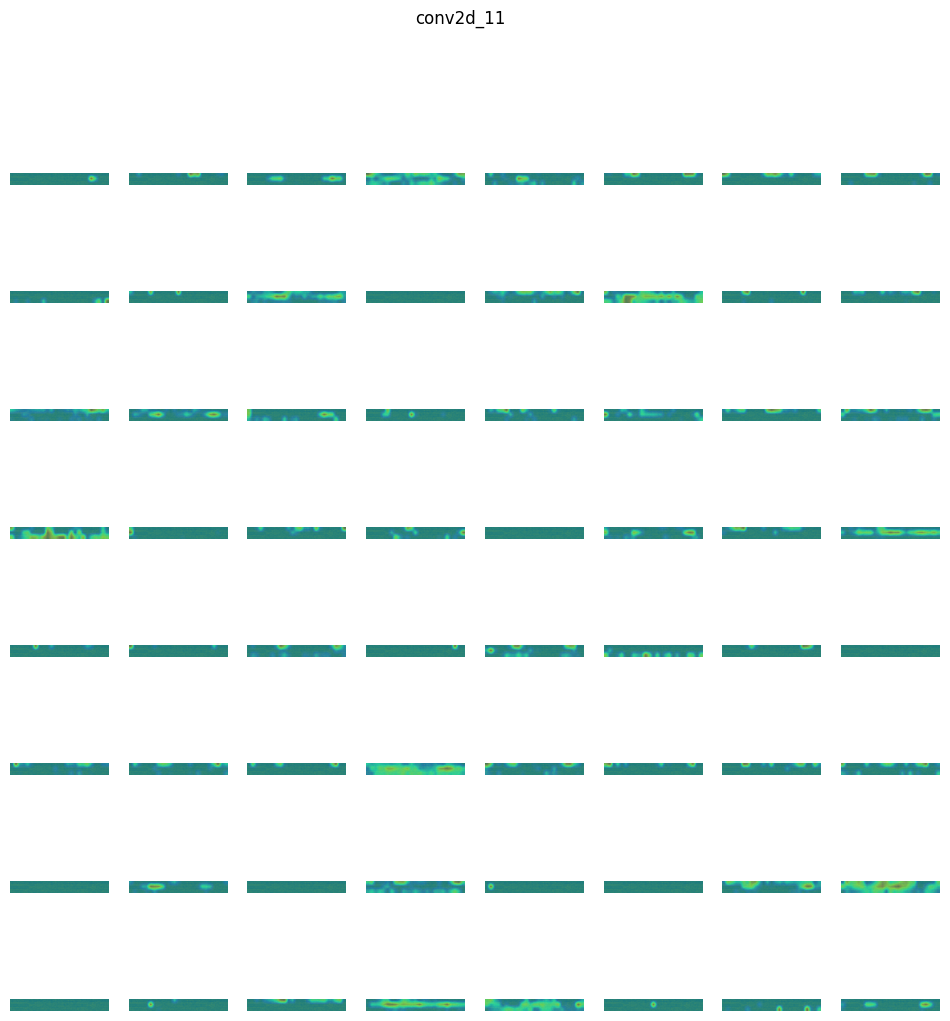

max_pooling2d_11 (1, 1, 12, 64) 


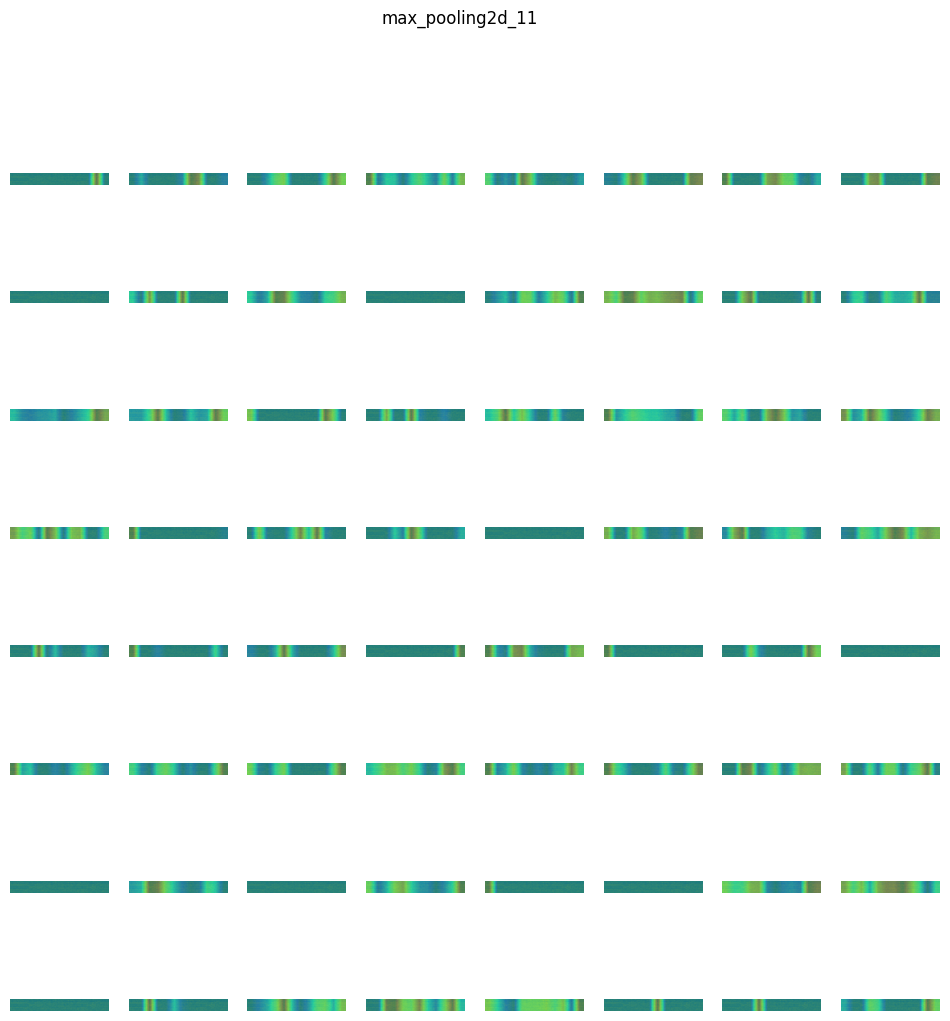

flatten_3 (1, 768) -> Skipped. 2D Activations.
dense_35 (1, 64) -> Skipped. 2D Activations.
dropout_24 (1, 64) -> Skipped. 2D Activations.
dense_36 (1, 2) -> Skipped. 2D Activations.


In [ ]:
display_heatmaps(activations, spectrogram, save=False, fix=True, merge_filters=False)